In [1]:
import fastai

In [2]:
print(fastai.__version__)

2.3.0


In [3]:
%matplotlib inline
from fastai.vision.all import *
from nbdev.showdoc import *

In [4]:
set_seed(2)
bs = 64

In [5]:
path = untar_data(URLs.PETS); path

Path('/home/gitpod/.fastai/data/oxford-iiit-pet')

In [6]:
Path.BASE_PATH = path # 显示相对于数据集根的所有路径
path.ls()

(#2) [Path('images'),Path('annotations')]

In [7]:
path_anno = path/'annotations'
path_img = path/'images'

In [8]:
fnames = get_image_files(path_img) # 获取部分文件名
fnames[:5]

(#5) [Path('images/British_Shorthair_201.jpg'),Path('images/Bengal_153.jpg'),Path('images/pomeranian_165.jpg'),Path('images/boxer_110.jpg'),Path('images/Birman_123.jpg')]

In [9]:
# 数据处理
dls = ImageDataLoaders.from_name_re(
    path, fnames, pat=r'(.+)_\d+.jpg$', item_tfms=Resize(460), bs=bs,num_workers=0,
    batch_tfms=[*aug_transforms(size=224, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])

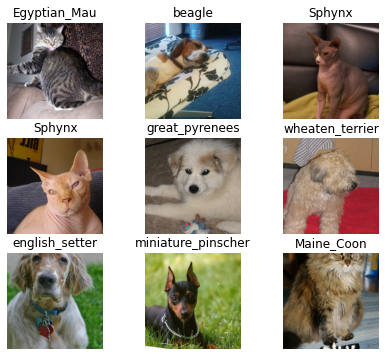

In [10]:
# 随机展示一下数据图片
dls.show_batch(max_n=9,figsize=(7,6))

In [11]:
print(dls.vocab) #查看所有标签
len(dls.vocab),dls.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

In [12]:
from ipywidgets import IntProgress
# 创建模型指定一些参数
learn = cnn_learner(dls, resnet34, metrics=error_rate).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/gitpod/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [13]:
# 查看模型
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [14]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [15]:
# 先训练4轮
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.940866,0.346764,0.115020,15:05
1,0.717887,0.239321,0.081867,29:10
2,0.442077,0.226484,0.083221,28:41
3,0.340533,0.229760,0.083221,28:51


In [16]:
# 保存模型
learn.save('stage-1')

Path('models/stage-1.pth')

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
# ClassificationInterpretationl类拥有用于创建混淆矩阵以及绘制分类错误的图像的方法
losses,idxs = interp.top_losses()

len(dls.valid_ds)==len(losses)==len(idxs)

In [18]:
# 对预测展示
learn.show_results()

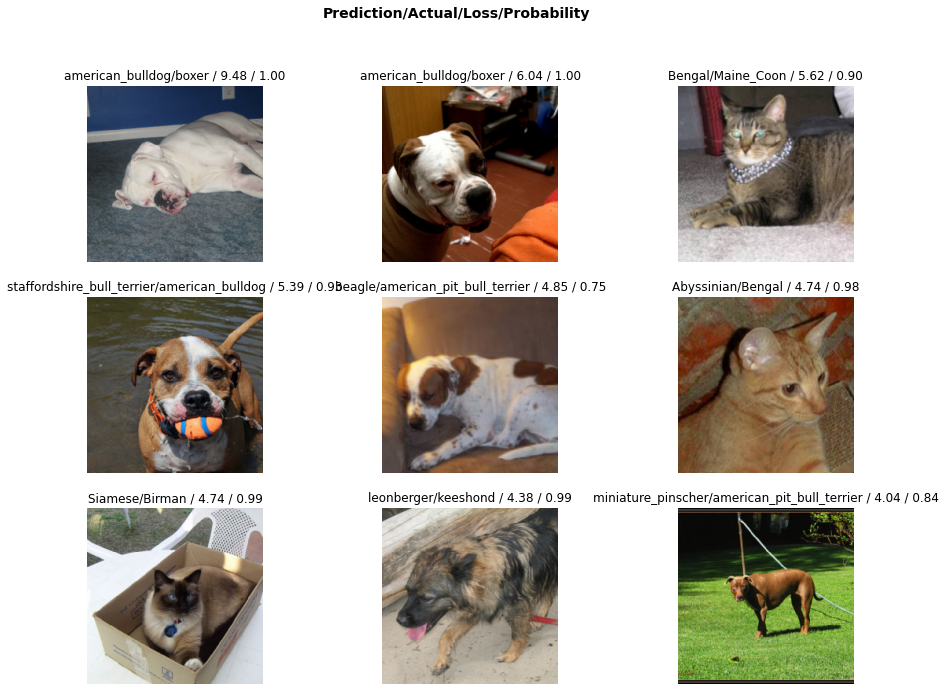

In [19]:
# 查看损失最大的几张图
interp.plot_top_losses(9, figsize=(15,11))

In [20]:
# 混淆矩阵查看
doc(interp.plot_top_losses)

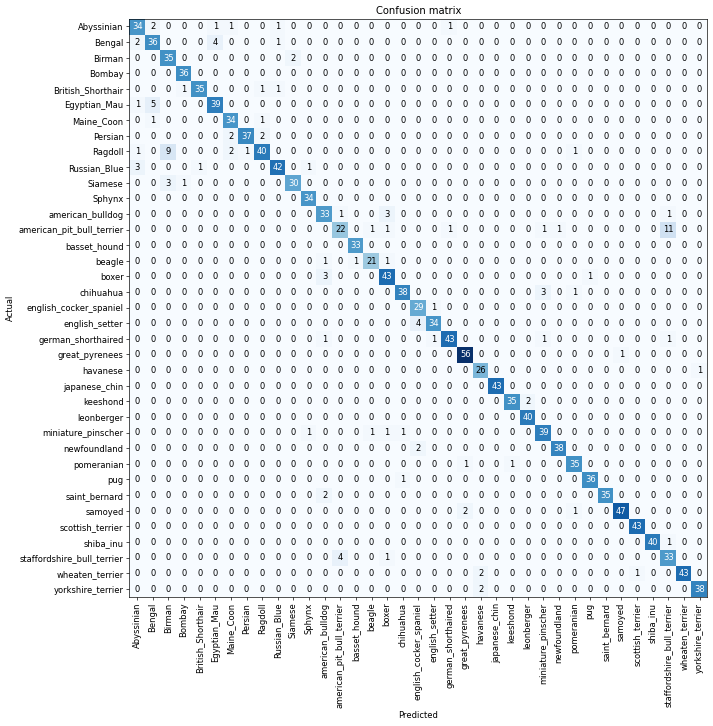

In [21]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [22]:
# 通过微调让模型更好
learn.unfreeze()  # 释放所有的参数
learn.fit_one_cycle(1) # 训练一次，但是我们将得到一个糟糕的结果

epoch,train_loss,valid_loss,error_rate,time
0,1.311291,0.601278,0.182679,38:20


In [23]:
# 查看loss曲线
learn.lr_find()

In [24]:
# 调整学习率
learn.unfreeze()
learn.fit_one_cycle(2, lr_max=slice(1e-6,1e-4))
# 似乎真确率提升

epoch,train_loss,valid_loss,error_rate,time
0,0.768090,0.504949,0.156292,39:36
1,0.725000,0.484531,0.150203,38:46


In [25]:
learn.lr_find()